# Open Source Delta-Sigma ADC Design

## 1. Introduction

### Motivation

This project was initiated as an opportunity to explore the [**IHP SiGe SG13G2 BiCMOS PDK**](https://ihp-open-pdk-docs.readthedocs.io/en/latest/process_specs/process_specs.html) open source PDK. Having recently completed a tapeout using the open-source **Skywater 130nm** process, I was interested in gaining experience with a different technology node. The SG13G2 process is also of growing relevance, with [**Tiny Tapeout**](https://tinytapeout.com/) expected to offer runs in this process in the near future. Additionally, Europractice provides regular [MPW](https://europractice-ic.com/schedules-prices-2025/) runs in this process at highly attractive price points, making it a viable option beyond Tiny Tapeout. This project also serves as a way to gain more hands-on experience with **open-source EDA tools**, and to develop a reusable piece of IP that could be of practical value to the open-source IC design community—particularly for sensor readout applications.


## 2. ADC Specifications

The specifications for this project are inspired by the **ADS1115**, a 16-bit, 860 samples-per-second delta-sigma ADC. This is a popular chip widely used in hobbyist and maker projects, often in combination with platforms like **Arduino** and **Raspberry Pi**—see [this breakout board from Adafruit](https://www.adafruit.com/product/1085) as an example.

Given its versatility and accessibility, the ADS1115 serves as a solid reference point for developing a general-purpose, high-resolution ADC suitable for the open-source hardware community. This IP could be valuable for the **readout of analog sensors** such as **strain gauges, thermistors, pressure sensors, photodiodes**, and other precision analog inputs commonly found in DIY instrumentation and embedded systems.

### 2.1 SQNR

From [ADS1115 datasheet](https://www.ti.com/lit/ds/symlink/ads1115.pdf?ts=1742739272984&ref_url=https%253A%252F%252Fwww.ti.com%252Fproduct%252FADS1115), the target ENOB is 16 bits, which from the equation below gives a target SQNR of about 100dB.

$$
SQNR\ [\mathrm{dB}] = 6.02 \cdot ENOB + 1.76
\tag{1}
$$
### 2.2 Supply Voltage

The IHP SG13G2 process offers two flavors of MOSFET. A low-voltage (thin-oxide) core MOSFET with a nominal operating voltage of 1.5V, and a high-voltage (thick-oxide) I/O MOSFET with a nominal operating voltage of 3.3V. Since the target application for this IP is as a general purpose hobbyist ADC meant to interface off-chip, a 3.3V supply will be targetted.

### 2.3 Power

The power dissipation for the ADS1115 is 0.5mW at VDD=3.3 (150μA), and that is chosen as the target specification for this IP.

### 2.4 Bandwidth

Based on the 860 samples-per-second specification from the ADS1115 datasheet, the target bandwidth for this converter will aim for a bandwidth of 500Hz.

### 2.5 Target Specifications

### Table 1.1: ADC Target Specifications

| **Parameter**             | **Symbol** | **Value** | **Units** |
|---------------------------|------------|-----------|-----------|
| Supply Voltage            | VDD        | 3.3       | V         |
| Current Consumption       | P          | 150       | µA        |
| Signal-To-Q-Noise Ratio   | SQNR       | 100       | dB        |
| Bandwidth                 | fB         | 500       | Hz       |


### 3.3 Order and OSR

The SQNR of an N-bit ΔΣ ADC with order M can be given by (2.1):

$$
SQNR = 10 \cdot \log_{10} \left( \frac{ \left( \frac{1}{2\sqrt{2}} \right)^2 }{ \frac{1}{12} \cdot \left( \frac{1}{2^N - 1} \right)^2 \cdot \left( \frac{\pi^{2M}}{2M + 1} \right) \cdot \left( \frac{1}{OSR} \right)^{2M + 1} } \right)
\tag{2.1}
$$

This expression is derived by making several simplifying assumptions including assuming a linear model of the converter. Despite these simplifying assumptions, this equation is a useful tool for picking a starting point before moving onto Python simulations for further refinement. Plotting (2.1) for N = 1 and M from 1 to 4 yields the figure shown below.



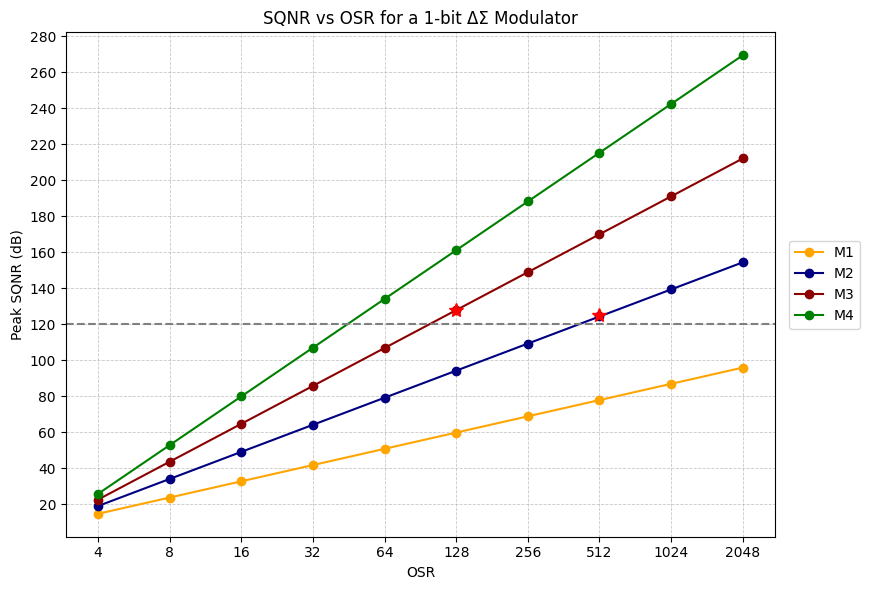

In [160]:
# Code for 3.3 to plot Order and OSR.

import numpy as np
import matplotlib.pyplot as plt

def compute_sqnr(OSR, M, N=1):
    """Compute SQNR in dB for a ΔΣ modulator of order M and bit-width N."""
    numerator = (1 / (2 * np.sqrt(2)))**2
    denominator = (1/12) * (1 / (2**N - 1))**2 * (np.pi**(2*M) / (2*M + 1)) * (1 / OSR)**(2*M + 1)
    sqnr = 10 * np.log10(numerator / denominator)
    return sqnr

# OSR values: powers of 2 from 4 to 2048
osr = 2 ** np.arange(2, 12)

# Modulator orders to plot
orders = [1, 2, 3, 4]
colors = ['orange', '#000080', '#8B0000', 'green']

plt.figure(figsize=(10, 6))

max_sqnr = 0  # We'll track max SQNR for auto-scaling the y-axis ticks

for M, color in zip(orders, colors):
    sqnr = compute_sqnr(osr, M)
    max_sqnr = max(max_sqnr, max(sqnr))
    plt.plot(osr, sqnr, marker='o', label=f'M{M}', color=color)

# Axis formatting
plt.xscale('log', base=2)
plt.xticks(osr, labels=osr)

# Dynamically generate y-ticks in steps of 20 dB up to the max SQNR
yticks = np.arange(0, np.ceil(max_sqnr / 20) * 20 + 1, 20)
plt.yticks(yticks)

plt.xlabel('OSR')
plt.ylabel('Peak SQNR (dB)')
plt.title('SQNR vs OSR for a 1-bit ΔΣ Modulator')

plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)

# Move legend outside the plot on the right
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0)

plt.tight_layout()
plt.subplots_adjust(right=0.78)

plt.axhline(y=120, color='gray', linestyle='--', linewidth=1.5, label='Target SQNR (120 dB)')

plt.plot(128, 128, 'r*', markersize=10)  # 'r*' = red star indicating design choice 1
plt.plot(512, 125, 'r*', markersize=10)  # 'r*' = red star indicating design choice 2

plt.show()




By adding 20dB to our 100dB SQNR target at this stage, we can provide margin to account for degradation due to circuit non-idealities. This target line is plotted in red and two starting design choices are marked with red stars.

The NTFs for these two design choices are synthesized and simulated using the synthesizeNTF, simulateDSM, and simulateSNR functions from the [Schreier Delta Sigma Toolbox in Python](https://www.python-deltasigma.io/). Harald Pretl's [fork](https://github.com/hpretl/python-deltasigma) of the toolkit was used for this project since it is more recently updated than the original by G. Venturini.

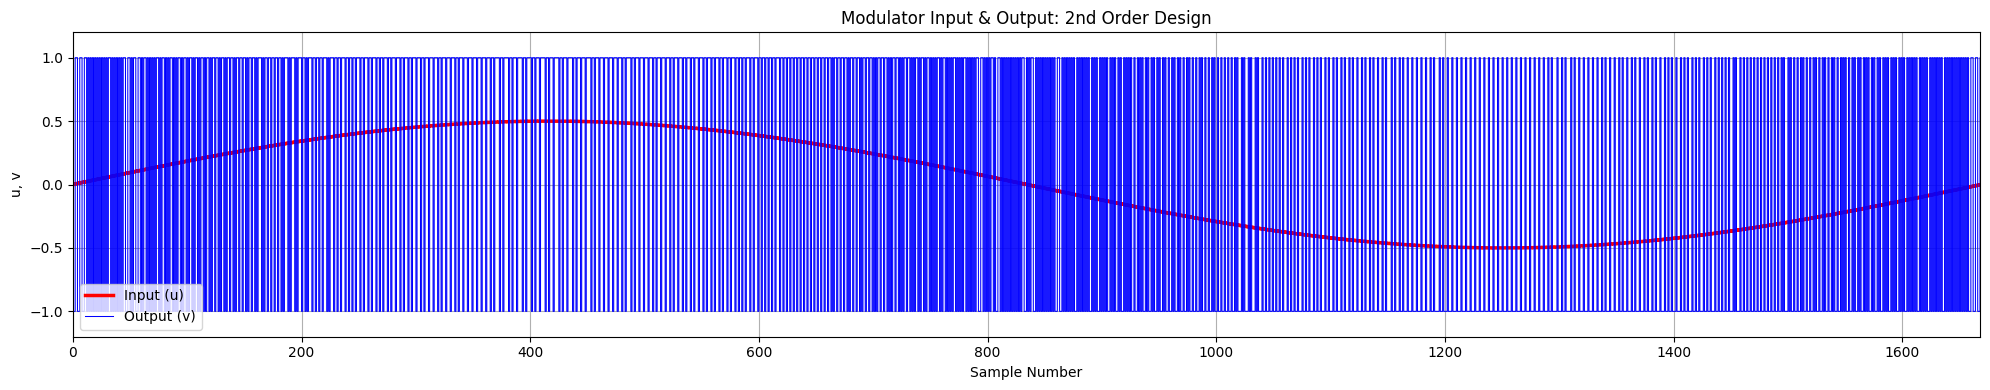

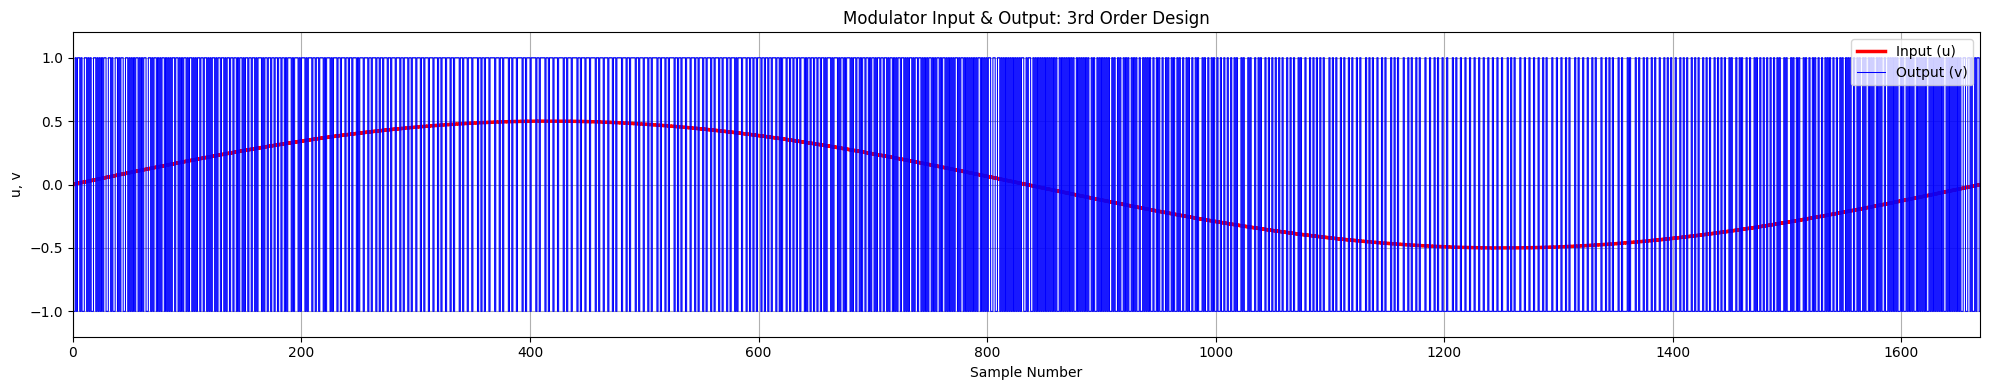

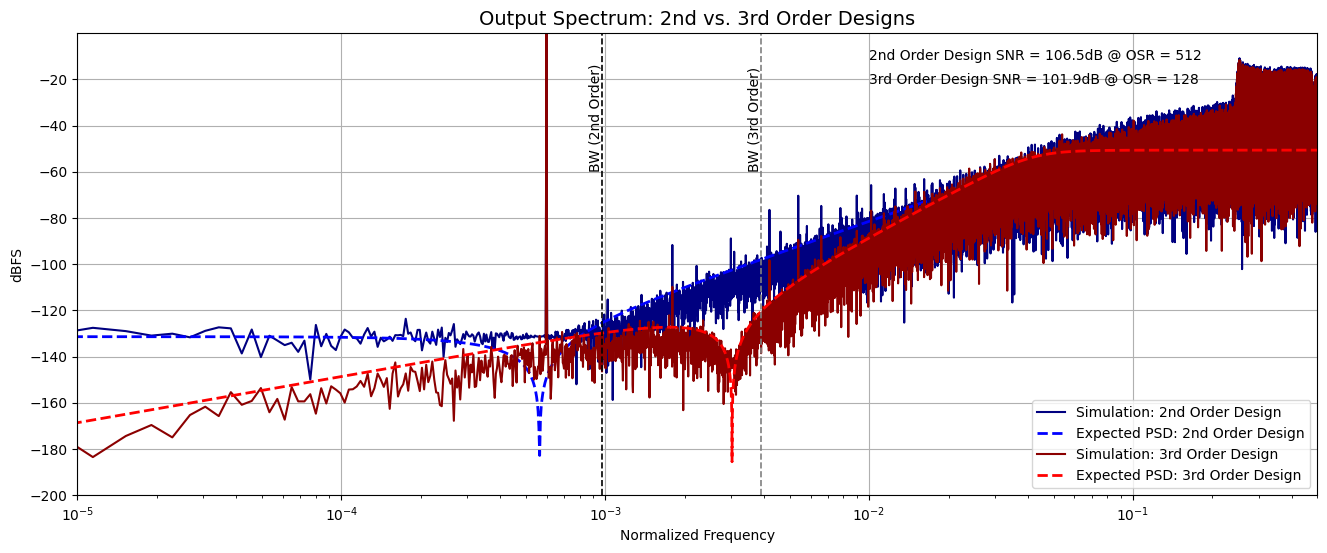

In [124]:
# Code for synthesizeNTF

from __future__ import division
from deltasigma import *
import numpy as np
import matplotlib.pyplot as plt

OSR1 = 512
OSR2 = 128
order1 = 2
order2 = 3
Hinf = 1.3 # OBG of NTF. More aggressive NTF means higher OBG (lower IBG), but trades with stability.
opt = 1 # A parameter which optimizes placement of zeroes to increase Maximum Signal Amplitude (MSA)

H1 = synthesizeNTF(order1, OSR1, opt, Hinf)
H2 = synthesizeNTF(order2, OSR2, opt, Hinf)

# Plot 2nd order design Python Simulation
plt.figure(figsize=(20, 4))
N = 18
N_rec_size = 2**N
N_record_array = np.arange(N_rec_size)


M_i = 157 # Number of input periods of sine wave to fit in a record.
         # Follow rule of fi/fs = M/2^L to avoid spectral leakage, where fi and fs are chosen to be relatively prime. M and L are integers.
         # fi = M/2^N -> Normalized input signal frequency.
         # 2^N = Record length. Chosen as a power of 2 to increase FFT speed.
         # This ensures zero spectral leakage. (So Hanning Window is not needed but left in code anyway).
         # 2^N should also be relatively prime with M_i (shares no integer divisors other than 1).
f_test_signal_normalized = np.pi * M_i / N_rec_size
fB1_normalized =  1 / (2*OSR1)
fB2_normalized = 1 / (2*OSR2)


u = 0.5 * np.sin(2 * np.pi * M_i / N_rec_size * N_record_array)



v1, xn1, xmax1, y1 = simulateDSM(u, H1)
plt.step(N_record_array, u[N_record_array], 'r', linewidth=2.5, label='Input (u)')
plt.step(N_record_array, v1[N_record_array], 'b', linewidth=0.75, label='Output (v)')
plt.axis([0, int(N_rec_size/M_i)-1, -1.2, 1.2])
plt.xlabel('Sample Number')
plt.ylabel('u, v')
plt.title('Modulator Input & Output: 2nd Order Design')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3rd order design Python Simulation

plt.figure(figsize=(20, 4))

v2, xn2, xmax2, y2 = simulateDSM(u, H2)

plt.step(N_record_array, u[N_record_array], 'r', linewidth=2.5, label='Input (u)')
plt.step(N_record_array, v2[N_record_array], 'b', linewidth=0.75, label='Output (v)')
plt.axis([0, N_rec_size/M_i-1, -1.2, 1.2])
plt.xlabel('Sample Number')
plt.ylabel('u, v')
plt.title('Modulator Input & Output: 3rd Order Design')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Run calculateSNR and plot 2nd order and 3rd order on same plot.

f = np.linspace(0, 0.5, int(N_rec_size/2. + 1))

# 2nd order
spec1 = np.fft.fft(v1) / (N_rec_size/4)
plt.plot(f, dbv(spec1[:int(N_rec_size/2. + 1)]),'#000080', label='Simulation: 2nd Order Design')
plt.xscale('log')
plt.xlim(1e-5,0.5)
figureMagic([0, 0.5], 0.05, None, [-200, 0], 20, None, (16, 6), 'Output Spectrum: 2nd vs. 3rd Order Designs')
plt.xlabel('Normalized Frequency')
plt.ylabel('dBFS')
snr1 = calculateSNR(spec1[2:int(N_rec_size/(2*OSR1))+1], M_i - 2)
plt.text(0.01, -10, '2nd Order Design SNR = %4.1fdB @ OSR = %d' % (snr1, OSR1), verticalalignment='center')
NBW = 1/N_rec_size # Signals chosen so no windowing is necessary; therefore NBW = 1 / Nrec. 1.5 / Nrec for Hanning.
Sqq = 4*evalTF(H1, np.exp(2j*np.pi*f)) ** 2/3.

plt.plot(f, dbp(Sqq * NBW), 'b', linestyle='--', linewidth=2, label='Expected PSD: 2nd Order Design')


#3rd order

# 3rd order
spec2 = np.fft.fft(v2) / (N_rec_size/4)
plt.plot(f, dbv(spec2[:int(N_rec_size/2. + 1)]), '#8B0000', label='Simulation: 3rd Order Design')  # red for 3rd order
plt.xscale('log')
plt.xlim(1e-5,0.5)
snr2 = calculateSNR(spec2[2:int(N_rec_size/(2*OSR2))+1], M_i - 2)
plt.text(0.01, -20, '3rd Order Design SNR = %4.1fdB @ OSR = %d' % (snr2, OSR2), verticalalignment='center')

Sqq2 = 4 * evalTF(H2, np.exp(2j * np.pi * f)) ** 2 / 3.
plt.plot(f, dbp(Sqq2 * NBW), 'r', linewidth=2, linestyle='--', label='Expected PSD: 3rd Order Design')  # cyan for 3rd order PSD



# Plot vertical lines at bandwidth edges
# Vertical line for 2nd-order bandwidth edge
plt.axvline(x=fB1_normalized, color='k', linestyle='--', linewidth=1.2)
plt.text(fB1_normalized, -60, 'BW (2nd Order)', rotation=90, fontsize=10,
         verticalalignment='bottom', horizontalalignment='right')

# Vertical line for 3rd-order bandwidth edge
plt.axvline(x=fB2_normalized, color='gray', linestyle='--', linewidth=1.2)
plt.text(fB2_normalized, -60, 'BW (3rd Order)', rotation=90, fontsize=10,
         verticalalignment='bottom', horizontalalignment='right')


plt.legend(loc=4);





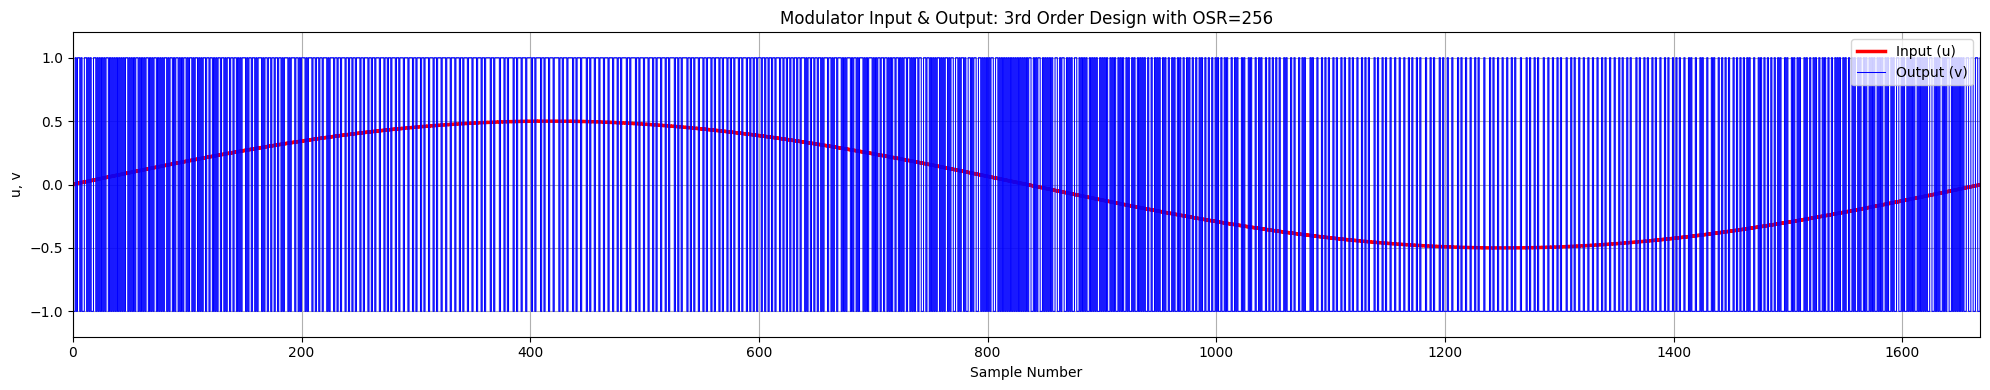

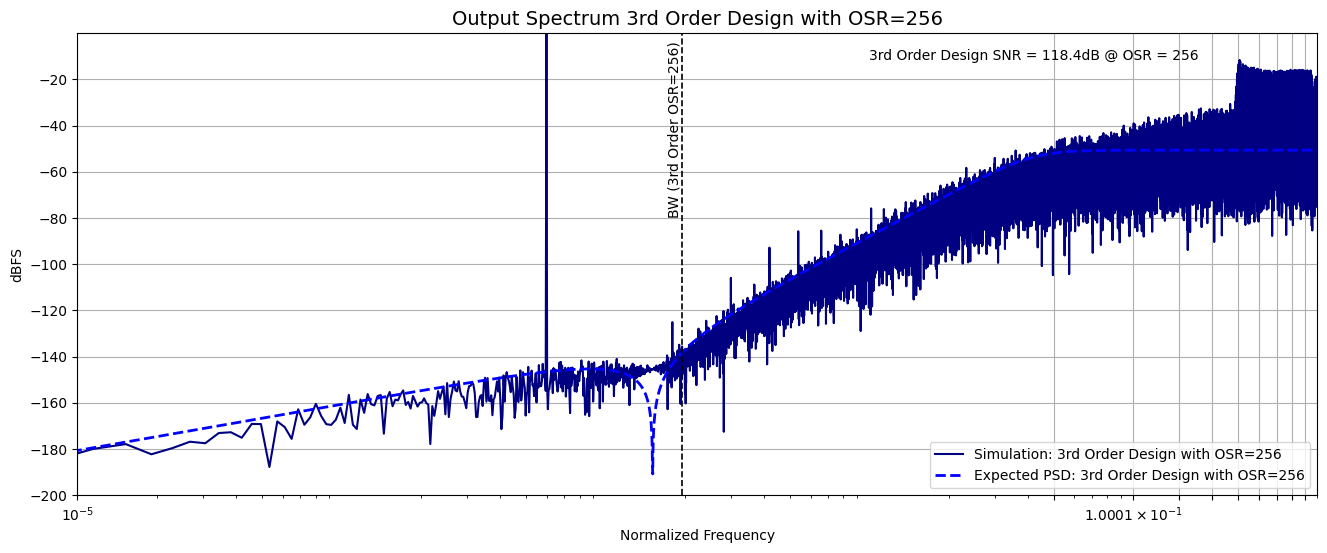

In [125]:
# Code for synthesizeNTF of a 3rd-order with OSR = 256

from __future__ import division
from deltasigma import *
import numpy as np
import matplotlib.pyplot as plt

OSR1 = 256
order1 = 3
Hinf = 1.3 # OBG of NTF. More aggressive NTF means higher OBG (lower IBG), but trades with stability.
opt = 1 # A parameter which optimizes placement of zeroes to increase Maximum Signal Amplitude (MSA)

H1 = synthesizeNTF(order1, OSR1, opt, Hinf)

# Plot 3rd order design Python Simulation
plt.figure(figsize=(20, 4))
N = 18
N_rec_size = 2**N
N_record_array = np.arange(N_rec_size)


M_i = 157 # Number of input periods of sine wave to fit in a record.
         # Follow rule of fi/fs = M/2^L to avoid spectral leakage, where fi and fs are chosen to be relatively prime. M and L are integers.
         # fi = M/2^N -> Normalized input signal frequency.
         # 2^N = Record length. Chosen as a power of 2 to increase FFT speed.
         # This ensures zero spectral leakage. (So Hanning Window is not needed but left in code anyway).
         # 2^N should also be relatively prime with M_i (shares no integer divisors other than 1).

f_test_signal_normalized = np.pi * M_i / N_rec_size
fB1_normalized =  1 / (2*OSR1)

u = 0.5 * np.sin(2 * np.pi * M_i / N_rec_size * N_record_array)


v1, xn1, xmax1, y1 = simulateDSM(u, H1)
plt.step(N_record_array, u[N_record_array], 'r', linewidth=2.5, label='Input (u)')
plt.step(N_record_array, v1[N_record_array], 'b', linewidth=0.75, label='Output (v)')
plt.axis([0, int(N_rec_size/M_i)-1, -1.2, 1.2])
plt.xlabel('Sample Number')
plt.ylabel('u, v')
plt.title('Modulator Input & Output: 3rd Order Design with OSR=256')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3rd order design Python Simulation

plt.figure(figsize=(20, 4))

# Run calculateSNR and plot 2nd order and 3rd order on same plot.

f = np.linspace(0, 0.5, int(N_rec_size/2. + 1))

# 3nd order with OSR=256
spec1 = np.fft.rfft(v1) / (N_rec_size/4)
plt.plot(f, dbv(spec1[:int(N_rec_size/2. + 1)]),'#000080', label='Simulation: 3rd Order Design with OSR=256')
#plt.plot(f, dbp(np.abs(spec1[:int(N_rec_size/2 + 1)])**2), '#000080', label='Simulation: 3rd Order Design with OSR=256')

plt.xscale('log')
plt.xlim(1e-5,0.5)
figureMagic([0, 0.5], 0.05, None, [-200, 0], 20, None, (16, 6), 'Output Spectrum 3rd Order Design with OSR=256')
plt.xlabel('Normalized Frequency')
plt.ylabel('dBFS')
snr1 = calculateSNR(spec1[2:int(N_rec_size/(2*OSR1))+1], M_i - 2)
plt.text(0.01, -10, '3rd Order Design SNR = %4.1fdB @ OSR = %d' % (snr1, OSR1), verticalalignment='center')
NBW = 1/N_rec_size # Signals chosen so no windowing is necessary; therefore NBW = 1 / Nrec. 1.5 / Nrec for Hanning.
Sqq = 4*evalTF(H1, np.exp(2j*np.pi*f)) ** 2/3.

plt.plot(f, dbp(Sqq * NBW), 'b', linestyle='--', linewidth=2, label='Expected PSD: 3rd Order Design with OSR=256')

# Plot vertical lines at bandwidth edges
# Vertical line for 2nd-order bandwidth edge
plt.axvline(x=fB1_normalized, color='k', linestyle='--', linewidth=1.2)
plt.text(fB1_normalized, -80, 'BW (3rd Order OSR=256)', rotation=90, fontsize=10,
         verticalalignment='bottom', horizontalalignment='right')



plt.legend(loc=4);



